# Linear Regression with Spark MLlib

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-3.2.1-bin-hadoop3.2"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.9.3-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [2]:
# Run this cell if you are using sklearn for the first time
!pip3 install -q sklearn --user
!pip3 install -q matplotlib

In [3]:
# Creating Spark Session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('LR_SparkML').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/21 17:40:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from sklearn import datasets
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
boston = datasets.load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['price'] = boston.target
df.head()

/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
sdf = spark.createDataFrame(df)
sdf.show(truncate=False)

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|CRIM   |ZN  |INDUS|CHAS|NOX  |RM   |AGE  |DIS   |RAD|TAX  |PTRATIO|B     |LSTAT|price|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0|2.31 |0.0 |0.538|6.575|65.2 |4.09  |1.0|296.0|15.3   |396.9 |4.98 |24.0 |
|0.02731|0.0 |7.07 |0.0 |0.469|6.421|78.9 |4.9671|2.0|242.0|17.8   |396.9 |9.14 |21.6 |
|0.02729|0.0 |7.07 |0.0 |0.469|7.185|61.1 |4.9671|2.0|242.0|17.8   |392.83|4.03 |34.7 |
|0.03237|0.0 |2.18 |0.0 |0.458|6.998|45.8 |6.0622|3.0|222.0|18.7   |394.63|2.94 |33.4 |
|0.06905|0.0 |2.18 |0.0 |0.458|7.147|54.2 |6.0622|3.0|222.0|18.7   |396.9 |5.33 |36.2 |
|0.02985|0.0 |2.18 |0.0 |0.458|6.43 |58.7 |6.0622|3.0|222.0|18.7   |394.12|5.21 |28.7 |
|0.08829|12.5|7.87 |0.0 |0.524|6.012|66.6 |5.5605|5.0|311.0|15.2   |395.6 |12.43|22.9 |
|0.14455|12.5|7.87 |0.0 |0.524|6.172|96.1 |5.9505|5.0|311.0|15.2   |396.9 |19.15|27.1 |
|0.21124|12.5|7.87 |0.0 |0.524|5

In [7]:
assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'price'],
                            outputCol='features')
dataset = assembler.transform(sdf)
sdf.show(truncate=False)

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|CRIM   |ZN  |INDUS|CHAS|NOX  |RM   |AGE  |DIS   |RAD|TAX  |PTRATIO|B     |LSTAT|price|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0|2.31 |0.0 |0.538|6.575|65.2 |4.09  |1.0|296.0|15.3   |396.9 |4.98 |24.0 |
|0.02731|0.0 |7.07 |0.0 |0.469|6.421|78.9 |4.9671|2.0|242.0|17.8   |396.9 |9.14 |21.6 |
|0.02729|0.0 |7.07 |0.0 |0.469|7.185|61.1 |4.9671|2.0|242.0|17.8   |392.83|4.03 |34.7 |
|0.03237|0.0 |2.18 |0.0 |0.458|6.998|45.8 |6.0622|3.0|222.0|18.7   |394.63|2.94 |33.4 |
|0.06905|0.0 |2.18 |0.0 |0.458|7.147|54.2 |6.0622|3.0|222.0|18.7   |396.9 |5.33 |36.2 |
|0.02985|0.0 |2.18 |0.0 |0.458|6.43 |58.7 |6.0622|3.0|222.0|18.7   |394.12|5.21 |28.7 |
|0.08829|12.5|7.87 |0.0 |0.524|6.012|66.6 |5.5605|5.0|311.0|15.2   |395.6 |12.43|22.9 |
|0.14455|12.5|7.87 |0.0 |0.524|6.172|96.1 |5.9505|5.0|311.0|15.2   |396.9 |19.15|27.1 |
|0.21124|12.5|7.87 |0.0 |0.524|5

In [8]:
dataset.select("features").show(truncate=False)

22/06/21 17:40:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------------------------------------------------------------------+
|features                                                                    |
+----------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]     |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14]    |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]   |
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94]   |
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33]    |
|[0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21]    |
|[0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.6,12.43]  |
|[0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.9,19.15]  |
|[0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93]|
|[0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,

In [9]:
dataset.cache() # <---

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: double, NOX: double, RM: double, AGE: double, DIS: double, RAD: double, TAX: double, PTRATIO: double, B: double, LSTAT: double, price: double, features: vector]

In [10]:
lr = LinearRegression(featuresCol='features', labelCol='price')
model = lr.fit(dataset)

22/06/21 17:40:22 WARN Instrumentation: [ca05dd3f] regParam is zero, which might cause numerical instability and overfitting.
22/06/21 17:40:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/06/21 17:40:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/06/21 17:40:23 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


## Importance of Individual Features

In [11]:
model.coefficients

DenseVector([-0.108, 0.0464, 0.0206, 2.6867, -17.7666, 3.8099, 0.0007, -1.4756, 0.306, -0.0123, -0.9527, 0.0093, -0.5248])

In [12]:
assembler.getInputCols()

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

<AxesSubplot:>

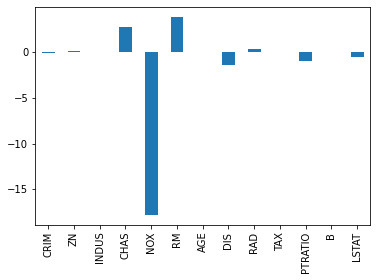

In [13]:
pd.Series(np.array(model.coefficients), index=assembler.getInputCols()).plot(kind='bar')

# Getting Metrics

In [14]:
summary = model.evaluate(dataset)
summary.r2

0.7406426641094093

In [15]:
summary.explainedVariance

62.52472497443503

## Training on a subset of the data

In [16]:
subset = sdf.select("CHAS", "NOX", "RM", "price")
assembler = VectorAssembler(inputCols=[c for c in subset.columns if c != 'price'],
                            outputCol='features')
small_dataset = assembler.transform(subset)
small_dataset.show()

+----+-----+-----+-----+-----------------+
|CHAS|  NOX|   RM|price|         features|
+----+-----+-----+-----+-----------------+
| 0.0|0.538|6.575| 24.0|[0.0,0.538,6.575]|
| 0.0|0.469|6.421| 21.6|[0.0,0.469,6.421]|
| 0.0|0.469|7.185| 34.7|[0.0,0.469,7.185]|
| 0.0|0.458|6.998| 33.4|[0.0,0.458,6.998]|
| 0.0|0.458|7.147| 36.2|[0.0,0.458,7.147]|
| 0.0|0.458| 6.43| 28.7| [0.0,0.458,6.43]|
| 0.0|0.524|6.012| 22.9|[0.0,0.524,6.012]|
| 0.0|0.524|6.172| 27.1|[0.0,0.524,6.172]|
| 0.0|0.524|5.631| 16.5|[0.0,0.524,5.631]|
| 0.0|0.524|6.004| 18.9|[0.0,0.524,6.004]|
| 0.0|0.524|6.377| 15.0|[0.0,0.524,6.377]|
| 0.0|0.524|6.009| 18.9|[0.0,0.524,6.009]|
| 0.0|0.524|5.889| 21.7|[0.0,0.524,5.889]|
| 0.0|0.538|5.949| 20.4|[0.0,0.538,5.949]|
| 0.0|0.538|6.096| 18.2|[0.0,0.538,6.096]|
| 0.0|0.538|5.834| 19.9|[0.0,0.538,5.834]|
| 0.0|0.538|5.935| 23.1|[0.0,0.538,5.935]|
| 0.0|0.538| 5.99| 17.5| [0.0,0.538,5.99]|
| 0.0|0.538|5.456| 20.2|[0.0,0.538,5.456]|
| 0.0|0.538|5.727| 18.2|[0.0,0.538,5.727]|
+----+-----

In [17]:
lr = LinearRegression(featuresCol='features', labelCol='price')
small_model = lr.fit(small_dataset)
summary = small_model.evaluate(small_dataset)

22/06/21 17:40:25 WARN Instrumentation: [1dc3317c] regParam is zero, which might cause numerical instability and overfitting.


In [18]:
summary.r2

0.5555737130590865

In [19]:
summary.explainedVariance

46.9012862684761

## Exercise: Fit a Linear Regression on the Diabetes Dataset
### Step 1: Create a spark DataFrame, and prepare the dataset
### Step 2: Find the R2 score and explained variance
### Step 3: Find a subset of features with the highest absolute coefficients (by plotting)
### Step 4: Train a new model on this subset, and find R2 and explained variance

In [20]:
# Step 1
diabetes = datasets.load_diabetes()
# complete code below
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target

sdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'target'],
                            outputCol='features')


dataset = assembler.transform(sdf)

In [21]:
# Step 2 - complete code below
lr = LinearRegression(featuresCol='features', labelCol='target')
model = lr.fit(dataset)
summary = model.evaluate(dataset)
print(summary.r2, summary.explainedVariance)

22/06/21 17:40:26 WARN Instrumentation: [bb08b304] regParam is zero, which might cause numerical instability and overfitting.


0.5177494254132933 3070.194498142278


<AxesSubplot:>

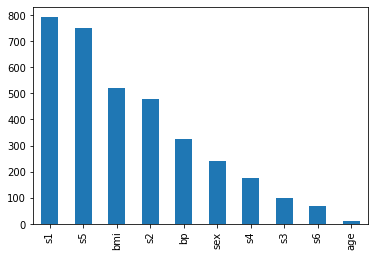

In [22]:
# Step 3:
pd.Series(np.array(model.coefficients), index=assembler.getInputCols()).abs().sort_values(ascending=False).plot(kind='bar')

In [23]:
# Step 4 - complete code below
subset = sdf.select("s1", "s5", "bmi", "s2", "target")
assembler = VectorAssembler(inputCols=[c for c in subset.columns if c != "target"],
                            outputCol="features")
small_dataset = assembler.transform(subset)

# lr = None
# model = None
# summary = None
lr = LinearRegression(featuresCol="features", labelCol="target")
small_model = lr.fit(small_dataset)
summary = small_model.evaluate(small_dataset)
print(summary.r2, summary.explainedVariance)

22/06/21 17:40:27 WARN Instrumentation: [3173e73f] regParam is zero, which might cause numerical instability and overfitting.


0.4764751603914341 2825.442857358116
